# Rent Prediction Project - Big Data Methods for Economists (UZH)

This notebook is a supplementary file for the submission of the Hands-On Project in the Course _MOEC0482: Big Data Methods for Economists_ at the University of Zurich.

We use a dataset on swiss real estate in order to predict a monthly renting price.

Supervisors: Dr. Massimo Mannino and Lin Xu

Authors: Felix Jost (15-067-861), Maxime Vandierendounck (16-730-137)

### Table of Contents

1. Exploratory Data Analysis and Manipulation
2. Machine Learning Techniques
3. Out of Sample Predictions
4. Appendix

In [1]:
# Installations (uncomment if necessary)
#!pip install xgboost==1.0.0 --user
#!pip install mlxtend
#!pip install timeit

# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats


# Sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline


#other Models
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor, StackingRegressor

#Timing
import timeit

# 1.  Exploratory Data Analysis and Manipulation

## 1.1 Load in the Data

We use both the training and testing files as we will do manipulation on both datasets later.

In [2]:
df_train = pd.read_csv("training.csv") # load in training file (including target variable)
df_train.head(3)

,id,GDENAMK,GDENR,KTKZ,address,area,balcony,basement,bath,cabletv,...,dist_to_5G,dist_to_haltst,dist_to_highway,dist_to_lake,dist_to_main_stat,dist_to_school_1,dist_to_train_stat,restaur_pix_count_km2,superm_pix_count_km2,dist_to_river
0,1,Chavornay,5749,VD,"Rue de Sadaz 15, 1373 Chavornay",80.0,NaN,NaN,NaN,NaN,...,12760.941970,542.609436,845.529420,NaN,542.609436,39.051248,542.609436,0,0,1232.655713
1,2,Grenchen,2546,SO,"Viaduktstrasse 8, 2540 Grenchen",90.0,1.0,NaN,NaN,1.0,...,8755.851529,78.517514,2880.772987,NaN,850.367568,413.146463,535.210239,7,0,1124.472721
2,3,Vevey,5890,VD,1800 Vevey,32.0,NaN,NaN,NaN,NaN,...,6926.931211,21.931712,2209.414402,166.0421,302.702825,140.035710,302.702825,45,5,6661.799045


In [3]:
df_test = pd.read_csv("X_test.csv") # load in testing file (target variable is missing)
df = df_train.append(df_test)
df

,id,GDENAMK,GDENR,KTKZ,address,area,balcony,basement,bath,cabletv,...,dist_to_5G,dist_to_haltst,dist_to_highway,dist_to_lake,dist_to_main_stat,dist_to_school_1,dist_to_train_stat,restaur_pix_count_km2,superm_pix_count_km2,dist_to_river
0,1,Chavornay,5749,VD,"Rue de Sadaz 15, 1373 Chavornay",80.0,NaN,NaN,NaN,NaN,...,12760.941970,542.609436,845.529420,NaN,542.609436,39.051248,542.609436,0,0,1232.655713
1,2,Grenchen,2546,SO,"Viaduktstrasse 8, 2540 Grenchen",90.0,1.0,NaN,NaN,1.0,...,8755.851529,78.517514,2880.772987,NaN,850.367568,413.146463,535.210239,7,0,1124.472721
2,3,Vevey,5890,VD,1800 Vevey,32.0,NaN,NaN,NaN,NaN,...,6926.931211,21.931712,2209.414402,166.042100,302.702825,140.035710,302.702825,45,5,6661.799045
3,4,Bern,351,BE,"Spitalackerstrasse 16, 3013 Bern BE",77.0,1.0,NaN,NaN,1.0,...,869.835042,69.462220,1390.906539,3528.066226,1537.693077,332.987988,1537.693077,11,3,438.552999
4,5,Winterthur,230,ZH,"Im Geissacker 40, 8404 Winterthur",NaN,1.0,NaN,NaN,1.0,...,575.800313,92.849340,2169.393694,2178.792308,2983.516382,136.619911,352.512411,2,2,897.649851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,17997,Wetzikon (ZH),121,ZH,"Mönchbergstrasse 6, 8623 Wetzikon ZH",92.0,1.0,NaN,NaN,1.0,...,7599.970658,285.506567,4504.613191,2579.063203,2377.705827,766.175567,1154.522412,1,1,613.270871
17997,17998,Kriens,1059,LU,"Schällenmatt 2, 6010 Kriens",124.0,1.0,1.0,NaN,NaN,...,2861.767461,318.135191,833.782945,NaN,673.624525,309.510904,673.624525,0,0,831.720263
17998,17999,Othmarsingen,4205,AG,"Högernweg 5, 5504 Othmarsingen",104.0,1.0,NaN,NaN,1.0,...,414.837317,110.453610,1406.334597,NaN,1216.963434,960.792381,964.577628,0,0,714.098221
17999,18000,Belp,861,BE,3123 Belp,67.0,NaN,NaN,NaN,NaN,...,1405.762427,39.395431,3026.615271,NaN,NaN,318.058171,97.000000,6,3,40.219716


## 1.2 Observing Missing Values

In [4]:
df.isnull().sum().sort_values(ascending = False).head(50)

manlift                90000
heating_pellets        89989
shower                 89988
heating_electro        89988
middle_house           89987
gardenshed             89987
oven                   89987
heating_earth          89973
pool                   89971
heating_air            89954
heating_far            89947
quiet                  89943
heating_gas            89937
sunny                  89932
heating_oil            89911
veranda                89909
water                  89887
terrace                89871
topstorage             89846
playground             89735
furnished              89721
bath                   89393
dryer                  89274
laundry                89229
raised_groundfloor     89095
basement               88756
toilets                88733
dishwasher             88521
oldbuilding            86752
cheminee               85853
kids_friendly          72905
parking_indoor         66449
parking_outside        66375
elevator               62647
year_built    

## 1.3 Deletion of specific Columns

We drop columns with more than 20k missing values, as well as those which have too many unique categorical entries.

In [5]:
df.nunique().sort_values(ascending = False).head()

id         72000
descr      61904
address    61477
lon        54902
lat        53556
dtype: int64

In [6]:
df = df[df.columns[df.isnull().sum() < 20000]] #Dropping the columns with less than 20k entries
df.isna().sum().sort_values(ascending = False).head(10)

rent_full              18001
area                   17838
Avg_size_household      2764
Anteil_auslaend         2660
Avg_age                 2660
rooms                   2304
avg_anzhl_geschosse     1946
avg_bauperiode          1946
anteil_efh              1943
dist_to_haltst           646
dtype: int64

In [7]:
df.nunique().sort_values(ascending = False).head()

id               72000
address          61477
lon              54902
lat              53556
dist_to_river    52029
dtype: int64

In [8]:
df.nunique().sort_values(ascending = True).head()

year                1
newly_built         2
quarter_specific    4
quarter_general     4
home_type           8
dtype: int64

In [9]:
df = df.drop(columns=['address','year'], axis=1) # address dropped due to uniqueness, year dropped as we only have 1 year (2019)
df

,id,GDENAMK,GDENR,KTKZ,area,date,home_type,lat,lon,month,...,avg_bauperiode,dist_to_4G,dist_to_5G,dist_to_haltst,dist_to_highway,dist_to_school_1,dist_to_train_stat,restaur_pix_count_km2,superm_pix_count_km2,dist_to_river
0,1,Chavornay,5749,VD,80.0,09.02.2019,Wohnung,46.714040,6.572320,2,...,1985.000000,279.517441,12760.941970,542.609436,845.529420,39.051248,542.609436,0,0,1232.655713
1,2,Grenchen,2546,SO,90.0,12.05.2019,Wohnung,47.195700,7.393598,5,...,1929.416667,226.497241,8755.851529,78.517514,2880.772987,413.146463,535.210239,7,0,1124.472721
2,3,Vevey,5890,VD,32.0,08.01.2019,Wohnung,46.460298,6.841865,1,...,1930.000000,38.327536,6926.931211,21.931712,2209.414402,140.035710,302.702825,45,5,6661.799045
3,4,Bern,351,BE,77.0,11.09.2019,Wohnung,46.954107,7.457753,9,...,1942.230769,97.693398,869.835042,69.462220,1390.906539,332.987988,1537.693077,11,3,438.552999
4,5,Winterthur,230,ZH,NaN,29.10.2019,Wohnung,47.514632,8.757234,10,...,1954.555556,457.283282,575.800313,92.849340,2169.393694,136.619911,352.512411,2,2,897.649851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,17997,Wetzikon (ZH),121,ZH,92.0,24.08.2019,Wohnung,47.329116,8.819225,8,...,1987.727273,336.856052,7599.970658,285.506567,4504.613191,766.175567,1154.522412,1,1,613.270871
17997,17998,Kriens,1059,LU,124.0,09.01.2019,Wohnung,47.026940,8.293521,1,...,2010.000000,97.169954,2861.767461,318.135191,833.782945,309.510904,673.624525,0,0,831.720263
17998,17999,Othmarsingen,4205,AG,104.0,15.10.2019,Wohnung,47.398048,8.206426,10,...,2003.400000,227.607118,414.837317,110.453610,1406.334597,960.792381,964.577628,0,0,714.098221
17999,18000,Belp,861,BE,67.0,04.04.2019,Wohnung,46.889780,7.498388,4,...,1982.200000,252.356890,1405.762427,39.395431,3026.615271,318.058171,97.000000,6,3,40.219716


## 1.4 Exploratory Data Analysis

Now let's take a look at our data a bit more. First lets look at the target variable 'rent_full'.

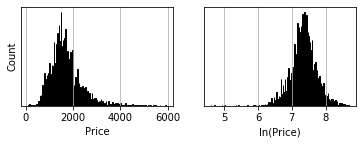

In [10]:
x = df.loc[:,"rent_full"][0:7200]
ln_x = np.log(x)

plt.subplot(2, 2, 1)
plt.hist(x, bins = 200, edgecolor = "black")
plt.ylabel("Count")
plt.xlabel("Price")
plt.yticks([])
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(ln_x, bins = 200, edgecolor = "black")
plt.xlabel('ln(Price)')
plt.ylabel('')
plt.yticks([])
plt.grid(True)

plt.show()

One can notice that rent prices are towards the left, which means that the data distribution is not normally distributed. Therefore, we decide to transform the target variable 'rent_full', taking the logarithm.

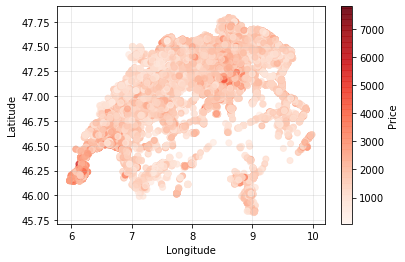

In [11]:
plt.scatter(df.loc[:, "lon"], df.loc[:, "lat"], c = df.loc[:, "rent_full"], alpha = 0.70, cmap = "Reds")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(axis = "x", alpha = 0.3)
plt.grid(axis = "y", alpha = 0.3)
plt.colorbar(label = "Price")

**To see an interactive choropleth Map, please refer to the appendix.**

We now create a correlation matrix to see what kind of variables are correlated with each other.

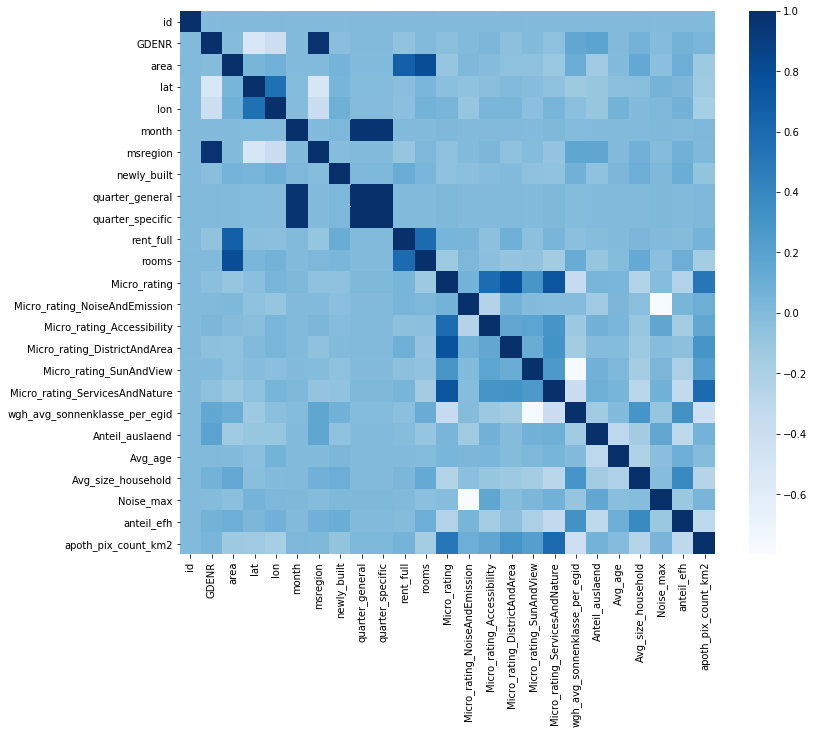

In [12]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.iloc[:,:-11].corr()
sns.heatmap(cor, annot=False, cmap = plt.cm.Blues)
plt.show()

## 1.6 Creating Dummy Variables out of Categorical Features

In [13]:
df.dtypes #Find categorical features left (we ignore ms_region as we drop it later)

id                                  int64
GDENAMK                            object
GDENR                               int64
KTKZ                               object
area                              float64
date                               object
home_type                          object
lat                               float64
lon                               float64
month                               int64
msregion                            int64
newly_built                         int64
quarter_general                     int64
quarter_specific                  float64
rent_full                         float64
rooms                             float64
Micro_rating                      float64
Micro_rating_NoiseAndEmission     float64
Micro_rating_Accessibility        float64
Micro_rating_DistrictAndArea      float64
Micro_rating_SunAndView             int64
Micro_rating_ServicesAndNature    float64
wgh_avg_sonnenklasse_per_egid     float64
Anteil_auslaend                   

In [14]:
# Create temporary DataFrame with Categorical Features
df_cat = df[["GDENAMK", "KTKZ", "home_type","month"]]
df_cat

,GDENAMK,KTKZ,home_type,month
0,Chavornay,VD,Wohnung,2
1,Grenchen,SO,Wohnung,5
2,Vevey,VD,Wohnung,1
3,Bern,BE,Wohnung,9
4,Winterthur,ZH,Wohnung,10
...,...,...,...,...
17996,Wetzikon (ZH),ZH,Wohnung,8
17997,Kriens,LU,Wohnung,1
17998,Othmarsingen,AG,Wohnung,10
17999,Belp,BE,Wohnung,4


In [15]:
# Count Unique Values
df_cat.nunique().sort_values(ascending = False).head()

GDENAMK      1886
KTKZ           26
month          11
home_type       8
dtype: int64

### Month

We only have data from 11 months in 2019.

([], <a list of 0 Text xticklabel objects>)

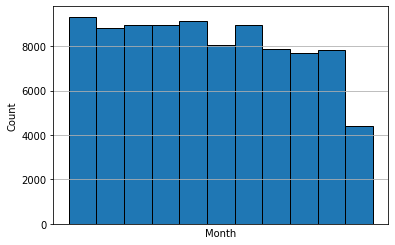

In [17]:
plt.hist(df["month"], bins = 11, edgecolor = "black")
plt.ylabel("Count")
plt.xlabel("Month")
plt.grid(axis = "both")
plt.xticks([])

In [18]:
df_mt = pd.get_dummies(df_cat["month"], drop_first=True, dummy_na = False, dtype=int)
df_mt

,2,3,4,5,6,7,8,9,10,11
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
17996,0,0,0,0,0,0,1,0,0,0
17997,0,0,0,0,0,0,0,0,0,0
17998,0,0,0,0,0,0,0,0,1,0
17999,0,0,1,0,0,0,0,0,0,0


### Gemeinde

In [19]:
df_cat['GDENAMK'].value_counts(dropna=False).head(45)

Zürich               5067
Basel                2678
Bern                 2385
Lausanne             2213
St. Gallen           1940
Genève               1745
Luzern               1605
Winterthur           1454
Biel/Bienne           971
Fribourg              952
Massagno              681
Schaffhausen          664
Sion                  591
Neuchâtel             589
Köniz                 558
La Chaux-de-Fonds     534
Chur                  515
Bulle                 467
Thun                  450
Emmen                 419
Dübendorf             418
Wil (SG)              405
Vevey                 402
Cheseaux-Noréaz       386
Frauenfeld            383
Kreuzlingen           377
Dietikon              375
Aarau                 367
Uster                 356
Lugano                348
Olten                 342
Kriens                333
Wetzikon (ZH)         326
Baden                 310
Renens (VD)           308
Arbon                 301
Nyon                  295
Rapperswil-Jona       294
Pully       

In [20]:
df_cat['CountGDE'] = df_cat.groupby(['GDENAMK'])['GDENAMK'].transform('count') #add counts of Gemeinde to each row

df_cat.loc[df_cat['CountGDE'] <= 100, 'GDENAMK'] = 'other' #Group all Municipilaties into "other" where we have less than 100 entries

df_gem = pd.get_dummies(df_cat["GDENAMK"], dummy_na = False, dtype=int, drop_first=False)
df_gem = df_gem.drop(columns=['other']) #drop the "other" category
df_gem

C:\Users\feljo\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\feljo\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Aadorf,Aarau,Aarburg,Adliswil,Affoltern am Albis,Aigle,Allschwil,Altstätten,Arbon,Arth,...,Winterthur,Wittenbach,Wohlen (AG),Wädenswil,Zofingen,Zollikofen,Zollikon,Zuchwil,Zug,Zürich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Wohungstyp

In [21]:
df_ht = pd.get_dummies(df_cat["home_type"], drop_first=False, dummy_na = False, dtype=int) # we drop the most common one "Wohnung" manually
df_ht = df_ht.drop(columns=['Wohnung'])
df_ht

,Attika,Dachwohnung,Ferienwohnung,Loft,Maisonette,Studio,Terrassenwohnung
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
17996,0,0,0,0,0,0,0
17997,0,0,0,0,0,0,0
17998,0,0,0,0,0,0,0
17999,0,0,0,0,0,0,0


In [22]:
df_cant = pd.get_dummies(df_cat["KTKZ"], drop_first=False ,dummy_na = False, dtype=int).drop(columns=['ZH']) #we drop the most common one, ZH
df_cant

,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SG,SH,SO,SZ,TG,TI,UR,VD,VS,ZG
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17999,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's merge the categorical columns back into the original dataframe.

In [24]:
df_full = pd.concat([df, df_mt, df_gem, df_cant], axis=1)
df_full = df_full.drop(columns=['GDENAMK','GDENR','KTKZ','home_type','lat','lon','month','date',
                                'msregion','quarter_general','quarter_specific'])
df_full

,id,area,newly_built,rent_full,rooms,Micro_rating,Micro_rating_NoiseAndEmission,Micro_rating_Accessibility,Micro_rating_DistrictAndArea,Micro_rating_SunAndView,...,SG,SH,SO,SZ,TG,TI,UR,VD,VS,ZG
0,1,80.0,0,1700.0,3.5,3.610,4.777778,6.071429,3.027027,8,...,0,0,0,0,0,0,0,1,0,0
1,2,90.0,0,1500.0,3.5,4.270,3.055556,7.089286,2.783784,10,...,0,0,1,0,0,0,0,0,0,0
2,3,32.0,0,920.0,1.5,5.620,5.222222,7.553571,3.608108,3,...,0,0,0,0,0,0,0,1,0,0
3,4,77.0,0,1640.0,3.5,6.215,6.944444,5.500000,6.756757,7,...,0,0,0,0,0,0,0,0,0,0
4,5,NaN,0,830.0,1.0,5.890,4.444444,6.803571,6.364865,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,17997,92.0,0,NaN,4.5,3.615,5.388889,2.767857,4.608108,3,...,0,0,0,0,0,0,0,0,0,0
17997,17998,124.0,0,NaN,4.5,4.675,3.611111,6.553571,5.770270,2,...,0,0,0,0,0,0,0,0,0,0
17998,17999,104.0,0,NaN,4.5,3.205,3.666667,4.607143,3.310811,9,...,0,0,0,0,0,0,0,0,0,0
17999,18000,67.0,0,NaN,3.5,6.910,3.388889,8.500000,6.932432,9,...,0,0,0,0,0,0,0,0,0,0


##### Sanity Check: We should only have integers and floats left

In [25]:
df_full.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90001 entries, 0 to 18000
Data columns (total 234 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   id                              int64  
 1   area                            float64
 2   newly_built                     int64  
 3   rent_full                       float64
 4   rooms                           float64
 5   Micro_rating                    float64
 6   Micro_rating_NoiseAndEmission   float64
 7   Micro_rating_Accessibility      float64
 8   Micro_rating_DistrictAndArea    float64
 9   Micro_rating_SunAndView         int64  
 10  Micro_rating_ServicesAndNature  float64
 11  wgh_avg_sonnenklasse_per_egid   float64
 12  Anteil_auslaend                 float64
 13  Avg_age                         float64
 14  Avg_size_household              float64
 15  Noise_max                       int64  
 16  anteil_efh                      float64
 17  apoth_pix_count_km2           

## 1.7 Imputing Missing Values

In [26]:
# Find Missing Values
df_full.isnull().sum().sort_values(ascending = False).head(15)

rent_full                        18001
area                             17838
Avg_size_household                2764
Anteil_auslaend                   2660
Avg_age                           2660
rooms                             2304
avg_anzhl_geschosse               1946
avg_bauperiode                    1946
anteil_efh                        1943
dist_to_school_1                   646
dist_to_haltst                     646
wgh_avg_sonnenklasse_per_egid       21
Einsiedeln                           0
Dietikon                             0
Emmen                                0
dtype: int64

We fill the most of the missing values with feature median. However, as we expect 'area' to be quite an important factor for predicting rent, we will predict the missing values with OLS.

In [27]:
cols = ['Avg_size_household','Anteil_auslaend','rooms','avg_bauperiode',
        'avg_anzhl_geschosse','anteil_efh','dist_to_school_1','dist_to_haltst',
        'wgh_avg_sonnenklasse_per_egid','Avg_age']

for col in cols:
    df_full[col] = df_full[col].fillna(df_full[col].median())

In [28]:
df_full.isnull().sum().sort_values(ascending = False).head(15)

rent_full             18001
area                  17838
ZG                        0
Châtel-Saint-Denis        0
Frauenfeld                0
Flawil                    0
Emmen                     0
Einsiedeln                0
Egg                       0
Ecublens (VD)             0
Ebikon                    0
Dübendorf                 0
Dietikon                  0
Delémont                  0
Davos                     0
dtype: int64

### Predict 'Area'

As area is an important variable, and still has quite a few Missing values, we estimate the values which are missing using simple OLS Linear Regression. It improves the results slightly (compared to using the median).

In [29]:
df_full.loc[df_full['area'] == 1, 'area'] = np.nan # We assume entries of '1' to be incorrect (60 entries)

X_area = df_full.dropna().drop(columns=['area','rent_full']) #we exclude rent_full as we dont have this info for the test set
y_area = df_full.dropna()['area']

lm = LinearRegression()

X_pred = df_full.drop(columns=['area','rent_full'])
lm.fit(X_area,y_area)
df_full['pred_area'] = lm.predict(X_pred)

df_full['area'] = df_full['area'].fillna(df_full['pred_area'])

df_full = df_full.drop(columns=['pred_area'])

## 1.8 Check for Multicollinearity

It is very likely that we have some features in our data set which are correlated with each other. A quick and easy way to see if this is the case is to look at the Variance Inflation Factor (VIF) of each feature.

In [30]:
# VIF dataframe
vif_data = pd.DataFrame()
df_full_no_rent = df_full.drop(columns=['rent_full'])
vif_data["feature"] = df_full_no_rent[:5000].columns # run only first 5000 columns as this is ressource intensive
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_full_no_rent[:5000].values, i)
                          for i in range(len(df_full_no_rent[:5000].columns))]
  
vif_data.sort_values(by='VIF',ascending = False).head(25)

C:\Users\feljo\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
4,Micro_rating,inf
5,Micro_rating_NoiseAndEmission,inf
6,Micro_rating_Accessibility,inf
7,Micro_rating_DistrictAndArea,inf
8,Micro_rating_SunAndView,inf
9,Micro_rating_ServicesAndNature,inf
51,Basel,1.801440e+14
161,Riehen,1.476590e+14
213,BS,9.898021e+13
18,avg_bauperiode,7.282143e+02


There is quite some Multicollinearity here. Clearly, we must get rid of those Variables with the VIF of 'inf'. Additionally, let's get rid of the features with a very high VIF. We experimented with different threshholds of what VIF is acceptable, and ultimately decided to use the ones below based on trial and error.

In [31]:
df_full = df_full.drop(columns=['Micro_rating',
                                'avg_bauperiode',
                                'wgh_avg_sonnenklasse_per_egid',
                                'BS'])

## 1.9 Check for Kurtosis and Skewness

All features were checked for kurtosis and skewness. While there is significant amount of kurtosis and skewness within some features, transforming them with various methods (including boxcox transformation) did not improve the results of the Machine Learning Techniques in any meaningful way. As such, this part has been excluded from our Notebook.

In general, our best performing models are decision tree based (XGBoost & Random Forest), and they can handle variables which are not normally distributed.

## 1.10 Dealing with Outliers

Here we drop the most extreme outliers in the dataset. We delete all the rows with a rent smaller than 350 or higher than 3500. After playing around with different threshholds this seemed to be a good way to approach the outliers.

In [32]:
df_complete = df_full.copy() #keep this for later

df_full.loc[(df_full.rent_full < 350) | (df_full.rent_full > 3500), 'rent_full' ] = 'Delete' #just using .drop() directly deletes the rows from X_test.csv
df_full = df_full.drop(df_full[df_full.rent_full=='Delete'].index)
df_full["rent_full"] = pd.to_numeric(df_full["rent_full"])
df_full = df_full.reset_index()

## 1.11 Dimensionality Reduction

As we now have a dataset with 230 features, we try to reduce these to the most important ones. We do this to save time when fitting our more advanced models, and to reduce the probability of overfitting.

For this we use the Sklearn Feature Selection using the 'SelectPercentile' Function where we set a percentage threshhold of how many variables we want to keep, and then select the most important ones using the linear regression model and the F-Score and P-Value as the metrics.

We set our threshhold of percentile = 65, as after trial and erorr it seemed to work well, and improved the results for the more advanced models (specifically, for XGB and RF). A full overview showing how the threshhold affects perfomance is available in the Appendix (4.1).

In [33]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression

y = np.log(df_full["rent_full"][0:69985]) #only take the training entries (from 'training.csv')
X_all = df_full.drop(['id',"rent_full"], axis = 1)[0:69985] #only take the training entries (from 'training.csv')

print(X_all.shape)
selector = SelectPercentile(f_regression, percentile=65)
X = selector.fit_transform(X_all,y)
print(X.shape)

(69985, 229)
(69985, 149)


# 2. Machine Learning Techniques

Below we will be running a couple of models:

Linear Regression based models:
1. Linear Regression
2. Lasso Regression
3. Ridge Regression

Distance based models:
4. K-Nearest Neighbors Regression

Decision Tree based ensemble models:
5. Random Forest
6. XGBoost

Meta Models:
7. Stacked Regression
8. Hybrid Prediction


## 2.1 Auxillarary Error Functions and set up

To help us with training the models and keeping the code clean, we define the function 'get_mse' which will automatically run through the different models using Cross Validation to get a reliable estimate of the performance.

As many of our Models are very time and ressource intensive to run, we limit our folds in our CV function to k=3.


In [36]:
errors={} # Initialise a dictionary where we will store the errors of the model.

kf = KFold(n_splits=3) #define amount of folds to do in k-fold CV

# Auxillary function using the cross validation score of the mse
def get_mse(model, X, y):
    start = timeit.default_timer() #start timer
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf) # get the MSE's of each fold
    stop = timeit.default_timer() # end timer
    print(f"CV - Runtime: {round((stop-start)/60,1)} minutes") 
    return (mse) #will return a list of mse's of all cv-runs

## 2.2 Linear Regression based Models


### 2.2.1 Linear Regression (Base for Comparison)

We use the standard OLS Linear Regression approach to predict the renting prices. This will act as our baseline model, upon which we will try to improve.

In [35]:
lm = LinearRegression()

error = get_mse(lm, X, y)
print("Linear Regression CV MSE: {:.4f}, Standard Deviation: ({:.4f})".format(error.mean(), error.std()))
errors['LinearReg'] = (error.mean(), error.std())

CV - Runtime: 0.0 minutes
Linear Regression CV MSE: 0.0446, Standard Deviation: (0.0015)


We will now experiment with Shrinkage Methods such as Ridge and Lasso.

### 2.2.2 Ridge

Here we use a data pipeline including RobustScaler. If we use the raw X data the ridge algorithm does not converge.

In [36]:
ridge_alphas =  np.linspace(1e-10, 10, 70)
ridge = make_pipeline(RobustScaler(),RidgeCV(cv=kf,alphas=ridge_alphas)) #take the best Ridge Model with the best alpha

error = get_mse(ridge, X, y)
print("Ridge Regression (mean) MSE: {:.4f}, Standard Deviation: ({:.4f})".format(error.mean(), error.std()))
errors['Ridge'] = (error.mean(), error.std())

CV - Runtime: 0.7 minutes
Ridge Regression (mean) MSE: 0.0446, Standard Deviation: (0.0015)


### 2.2.3 Lasso

Here we use a data pipeline including RobustScaler. If we use the raw X data the lasso algorithm does not converge.

In [37]:
lasso_alphas = np.linspace(1e-10, 10, 70)
lasso = make_pipeline(RobustScaler(),LassoCV(cv=kf,alphas = lasso_alphas, max_iter=5000))

error = get_mse(lasso, X, y)
print("Lasso Regression (mean) MSE: {:.4f}, Standard Deviation: ({:.4f})".format(error.mean(), error.std()))
errors['Lasso'] = (error.mean(), error.std())

CV - Runtime: 0.1 minutes
Lasso Regression (mean) MSE: 0.0446, Standard Deviation: (0.0015)


## 2.3 Distance based Models

### 2.3.1 K-Nearest Neighbors Regression (SKlearn)

We further experiment using k-Nearest Neighbors Regression. This method takes the k-closest neighbors of our new datapoint and assigns the new datapoint the average of these neighbors. As this method is distance-based, it is important to use scaling methods as we do not want the unit sizes of the features to distort the distance.

The Hyperparamater tuning was done by using Grid Search. The Grid Search code is available in the Appendix

In [38]:
# Best Hyperparamaters found via Grid Search

knr = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors = 9, n_jobs=-1))

error = get_mse(knr, X, y)
print("KNN Regression (mean) MSE: {:.4f}, Standard Deviation: ({:.4f})".format(error.mean(), error.std()))
errors['KNN'] = (error.mean(), error.std())

CV - Runtime: 2.2 minutes
KNN Regression (mean) MSE: 0.0535, Standard Deviation: (0.0008)


## 2.4 Decision Tree based Models

We now will try to predict renting prices with decision tree based models.

### 2.4.1 Random Forest (SKlearn)

First we will try to see if a Random Forest Regressor will give us good results. A random forest is an ensemble regression technique which builds many simple decision trees on random subsamples of the data, and then averages the results.

Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor

The Hyperparamater tuning was done by using Grid Searches. Initial Grid Searches tried to pinpoint specific hyperparameters, after which more broader Grid Searches were done. The Grid Search code is available in the Appendix and serves as an example, it does not show all grid searches tested.

In [39]:
# Best Parameters found by GridSearchCV
rf = RandomForestRegressor(n_estimators = 250,
                           max_features = 'sqrt',
                           min_samples_leaf=2,
                           min_samples_split=6,
                           max_depth = 45,
                           oob_score='True',
                           random_state = 0,
                           n_jobs=-1)

error = get_mse(rf, X, y)
print("RF Regression (mean) MSE: {:.4f}, Standard Deviation: ({:.4f})".format(error.mean(), error.std()))
errors['RF'] = (error.mean(), error.std())

CV - Runtime: 0.6 minutes
RF Regression (mean) MSE: 0.0384, Standard Deviation: (0.0009)


### 2.4.2 Extreme Gradient Boosting (XGBoost Library)

Next we try a Prediction method which is particularly popular in Kaggle Data Science Competitions.

XGBoost stands for "Extreme Gradient Boosting," where the term "Gradient Boosting" originates from Friedman (1999). Like random forests, gradient boosting is a set of decision trees, a series of sequential steps designed to answer a question and provides probabilities, costs, or other information, which are then aggregated.
The two main differences between the XGBoost and Random Forest techniques are:
1.	How trees are built: random forests build each tree independently, while gradient boosting builds one tree at a time. This ensemble model works in a forward stage-wise manner.
2.	Combining results: random forests combine results at the end of the process (by averaging or "majority rules") while gradient boosting combines results along the way.

Documentation: https://xgboost.readthedocs.io/en/latest/index.html

The Hyperparamater tuning was done by using Grid Searches. Initial Grid Searches tried to pinpoint specific hyperparameters, after which more broader Grid Searches were done. The Grid Search code is available in the Appendix and serves as an example, it does not show all grid searches tested.

##### Grid Search for Hyperparameters:

In [38]:
# Best Hyperparameters set by GridSearchCV

GBoost = XGBRegressor(colsample_bytree=0.7,
                      colsample_bynode=0.7,
                      colsample_bylevel=0.8,
                      gamma=0.1,
                      learning_rate=0.1,
                      max_depth=25,
                      min_child_weight=1.1,
                      n_estimators=200,
                      n_jobs=-1,
                      random_state=0,
                      max_features='None')



error = get_mse(GBoost, X, y)
print("XGB Regression (mean) MSE: {:.4f}, Standard Deviation: ({:.4f})".format(error.mean(), error.std()))
errors['XGB'] = (error.mean(), error.std())

CV - Runtime: 2.1 minutes
XGB Regression (mean) MSE: 0.0339, Standard Deviation: (0.0006)


## 2.5 Meta Models

In the following 2 models we will create 2 models which use other models as input. 

1. Stacking models sequentially (Stacked Regression)
2. Taking a weighted average of the models predictions (Hybrid Regression)

### 2.5.1 Stacked Regression

This ensemble method uses the Linear Regression Model, the XGB Model, and the RF Model, and then fits a new additional linear regressor on top of these basic models.

Documentation: https://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

The hyperparamater tuning was done through trial and error attempts, grid searchers were not utilized as they are very time intensive to run.

We only used Models which outperformed basic Linear Regression in this stacked model. Unfortunately, we could not outperform the XGB algorithm with this method. As such, we will not use it for prediction.

In [41]:
stack = StackingRegressor(regressors=(rf, GBoost, lm),
                                meta_regressor=lm,
                                use_features_in_secondary=True)

error = get_mse(stack, X, y)
print("Stacked Regression (mean) MSE: {:.4f}, Standard Deviation: ({:.4f})".format(error.mean(), error.std()))
errors['Stacked'] = (error.mean(), error.std())

CV - Runtime: 3.3 minutes
Stacked Regression (mean) MSE: 0.0359, Standard Deviation: (0.0006)


##### Selection of Hyperparameters and their respective Performance*

**Model**|**Run 1**|**Run 2**|**Run 3**|**Run 4**
:-----:|:-----:|:-----:|:-----:|:-----:
Linear Model|0|1|1|1
Random Forest|1|0|1|1
XGBoost|1|1|0|1
Meta Estimator|Linear Model|Linear Model|Linear Model|Linear Model
Use features in secondary|1|1|1|1
MSE|0.0359|0.0361|0.0383|0.0359

\* not all runs are shown here. Italic numbers indicate the hyperparameter of interest in each run.

### 2.3.2 Hybrid Model

As all of the models above performed fairly well, we were curious to see if we could improve upon the MSE by mixing many models together. We computed a weighted average of the different predictions, using all models except OLS. The idea behind this approach is that each model is overfitting the data in some way, and that a weighted average of the models will allow models to compensate for the specific overfitting of the other models.

Unfortunately, the get_mse command doesn't work here, as we aren't using a function that will have a ".fit()" command so we use a 'dirty' workaround here, splitting the test data into 1/3 _randomly_ using the train_test_split command.

We were able to outperform XGB very slightly within out sample data. Unfortunately however XGB still performed better in the actual testing data. (Information was given to us by lin).

Warning, running this code will take a long time.

In [42]:
# Best hyperparameters
def hybrid_model(X):
    return ((0.25 * lm_full.predict(X)) + 
            (0.25 * GBoost_full.predict(X)) + 
            (0.25 * rf_full.predict(X)) + 
            (0.25 * stack_full.predict(X)))

mse_hy=[]
start = timeit.default_timer() #start timer
for i in range(3):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = i) #split data

    # train all models only with training data
    lm_full = lm.fit(X_train,y_train)
    print(f"Run {i+1}: LM fitted")
    GBoost_full = GBoost.fit(X_train,y_train)
    print(f"Run {i+1}: XGB fitted")
    rf_full = rf.fit(X_train,y_train)
    print(f"Run {i+1}: Random Forest fitted")
    stack_full = stack.fit(X_train,y_train)
    print(f"Run {i+1}: Stack fitted")
    print(f"Run {i+1}: All Models Trained")
    
    pred_hy = hybrid_model(X_test)
    mse_hy.append(mean_squared_error(pred_hy, y_test))
    print(f"Run {i+1} mse: {mse_hy[i]}")
    
errors['Hybrid']= (np.mean(mse_hy), np.std(mse_hy))
print("Hybrid Regression MSE:",np.mean(mse_hy))
stop = timeit.default_timer() #stop timer
print(f"Runtime: {round((stop-start)/60,1)} minutes") 

Run 1: LM fitted
Run 1: XGB fitted
Run 1: Random Forest fitted
Run 1: Stack fitted
Run 1: All Models Trained
Run 1 mse: 0.034370559910561004
Run 2: LM fitted
Run 2: XGB fitted
Run 2: Random Forest fitted
Run 2: Stack fitted
Run 2: All Models Trained
Run 2 mse: 0.03401044773515585
Run 3: LM fitted
Run 3: XGB fitted
Run 3: Random Forest fitted
Run 3: Stack fitted
Run 3: All Models Trained
Run 3 mse: 0.03303423131622505
Hybrid Regression MSE: 0.033805079653980635
Runtime: 6.6 minutes


##### Selection of Hyperparameters and their respective Performance* 

**Model Weight**|**Run 1**|**Run 2**|**Run 3**|**Run 4**|**Run 4**|**Run 5**|**Run 6**|
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
Linear Model|0.33|0|0.25|0.25|0.20|0.20|0.25|...|...|...
XGBoost|0.34|0.50|0.25|0.50|0.40|0.40|0.40|...|...|...
Random Forest|0.33|0.50|0.25|0.25|0.20|0.30|0.25|...|...|...
Stack Model|0|0|0.25|0|0.20|0.10|0.10|...|...|...
MSE|0.0352|0.0342|0.0338|0.0342|0.0335|0.0339|0.0346|...|...|...

\* not all runs are shown here.

#### Compare the MSE's

Now we can compare how the different models perform. We are using the square root of the MSE here, with the y variable being in log.

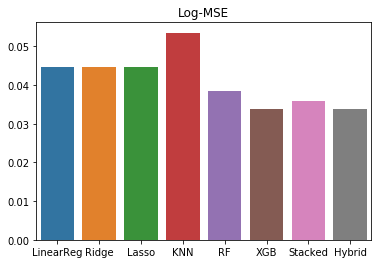

In [43]:
# create DataFrame for easier Plotting
errors_df = pd.DataFrame(errors).transpose() 
mse_df = (errors_df[[0]]).transpose()

# Plotting
ax = sns.barplot(data=mse_df).set_title('Log-MSE')

We can see that the XGB and Hybrid models performs the best.

# 3. Out of Sample Prediction

## 3.1 Fitting all models with complete training set

As we used CV before to get the performances of the Estimators, we were only training with parts of the data. For the final estimates we will use the complete training set and therefore we need to re-fit the models.

We are not using Lasso and Ridge as they did not improve over basic Linear Regression.

In [44]:
print("Fitting LM")
lm_full = lm.fit(X,y)

print("Fitting Ridge")
ridge_full = ridge.fit(X,y)

print("Fitting Lasso")
lasso_full = lasso.fit(X,y)

print("Fitting Linear SVR")
knr_full = knr.fit(X,y)

print("Fitting Random Forest")
rf_full = rf.fit(X,y)

print("Fitting XGB")
GBoost_full = GBoost.fit(X,y)

print("Fitting Stacked Regression")
stack_full = stack.fit(X,y)

print("All Models trained")

Fitting LM
Fitting Ridge
Fitting Lasso
Fitting Linear SVR
Fitting Random Forest
Fitting XGB
Fitting Stacked Regression
All Models trained


### 3.2 Predictions

Now let's do the predictions for the hold out set.

First we will create a dataset for the predictions. We use the the dataset 'df_complete' which we created earlier.

In [45]:
df_complete.reset_index(inplace=True)

y_complete = df_complete["rent_full"]
y_complete_log = np.log(df_complete["rent_full"])
X_complete = df_complete.drop(['id',"rent_full"], axis = 1)
X_complete = selector.transform(X_complete) #take the same columns as we did above in the chapter Dimensionality Reduction

print(X.shape, y.shape)

(69985, 149) (69985,)


Now we make predictions with our 2 best models, XGBoost and Hybrid.

We save the predictions as a .csv file for our final submission.

In [46]:
# Final Prediction for XGB and Hybrid Model
df_complete['pred_XGB'] = GBoost_full.predict(X_complete)         # log predictions
df_complete['pred_XGB_abs'] = np.exp(df_complete.pred_XGB)        # turn into absolute values
df_complete['pred_Hybrid'] = hybrid_model(X_complete)             # log predictions
df_complete['pred_Hybrid_abs'] = np.exp(df_complete.pred_Hybrid)  # turn into absolute values

df_complete.loc[72000:,['id','pred_XGB_abs']].to_csv('predictions_xgb_final.csv', index=False) #save predictions as csv.
df_complete.loc[72000:,['id','pred_Hybrid_abs']].to_csv('predictions_hyb_final.csv', index=False)
df_complete.loc[:,['id','rent_full','pred_XGB_abs','pred_Hybrid_abs']].to_csv('predictions_crosscheck_final.csv', index=False)

### 3.3 Comparison Within-Sample MSE vs. Out-of-Sample MSE

Finally, let's take a look at how our error is when not splitting the data in training and testing split.

In [47]:
lm_pred = lm_full.predict(X)
ridge_pred = ridge_full.predict(X)
lasso_pred = lasso_full.predict(X)
GBoost_pred = GBoost_full.predict(X)
rf_pred = rf_full.predict(X)
knr_pred = knr_full.predict(X)
stack_pred = stack_full.predict(X)
hybrid_pred = hybrid_model(X)

errors_df['In-Sample MSE'] = np.nan
errors_df.loc['LinearReg','In-Sample MSE'] = mean_squared_error(lm_pred, y)
errors_df.loc['Ridge','In-Sample MSE'] = mean_squared_error(ridge_pred, y)
errors_df.loc['Lasso','In-Sample MSE'] = mean_squared_error(lasso_pred, y)
errors_df.loc['XGB','In-Sample MSE'] = mean_squared_error(GBoost_pred, y)
errors_df.loc['RF','In-Sample MSE'] = mean_squared_error(rf_pred, y)
errors_df.loc['KNN','In-Sample MSE'] = mean_squared_error(knr_pred,y)
errors_df.loc['Stacked','In-Sample MSE'] = mean_squared_error(stack_pred, y)
errors_df.loc['Hybrid','In-Sample MSE'] = mean_squared_error(hybrid_pred, y)

errors_df = errors_df.rename(columns={0: "MSE", 1: "StdDev"})
errors_df

,MSE,StdDev,In-Sample MSE
LinearReg,0.044635,0.001536,0.044346
Ridge,0.044632,0.001545,0.044348
Lasso,0.044635,0.001536,0.044346
KNN,0.053544,0.000781,0.040435
RF,0.038352,0.000905,0.018690
XGB,0.033936,0.000627,0.011165
Stacked,0.035879,0.000601,0.009310
Hybrid,0.033805,0.000565,0.015573


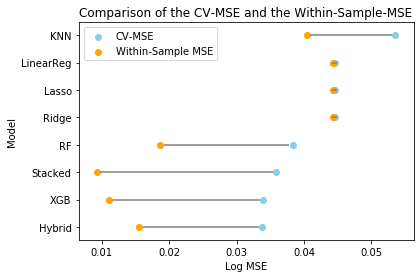

In [55]:
errors_df_l = errors_df.copy()
errors_df_l = errors_df_l.reset_index()

# Reorder it following the values of the first value:
ordered_df = errors_df_l.sort_values(by='MSE')
my_range=range(1,len(errors_df.index)+1)
 
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=ordered_df['MSE']-0.0005, xmax=ordered_df['In-Sample MSE']+0.0005, color='grey', alpha=1)
plt.scatter(ordered_df['MSE'], my_range, color='skyblue', alpha=1, label='CV-MSE')
plt.scatter(ordered_df['In-Sample MSE'], my_range, color='orange', alpha=1 , label='Within-Sample MSE')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ordered_df['index'])
plt.title("Comparison of the CV-MSE and the Within-Sample-MSE", loc='left')
plt.xlabel('Log MSE')
plt.ylabel('Model')

# Show the graph
plt.show()

Large distances between the two points can be explained in 2 ways:
1. The algorithm is overfitting
2. The algorithm significantly improves with more data

# 4 Appendix

## 4.1 Dimensionality Reduction - Percentage of Features used

The table below shows the models performance by each Percentile set in the Dimenstionality Reduction Section.

In [ ]:
errors_p = pd.DataFrame(columns = ['Percentile','LM','XGB','RF','KNR']) #Create Dataframe to store MSE's

grid = np.linspace(25,100,25) #Set the Percentiles that we want to check

for i,p in enumerate(grid): #loop through all percentiles, running the models and storing the MSE's
    print("-------------------------------------------")
    print(f"Run {i+1} | Fraction of Features used: {p:.2f}%")
    errors_p.loc[i,'Percentile'] = p
    selector = SelectPercentile(f_regression, percentile=p)
    X_p = selector.fit_transform(X_all,y)


    errors_p.loc[i,'XGB'] = get_mse(GBoost, X_p, y).mean()
    errors_p.loc[i,'RF'] = get_mse(rf, X_p, y).mean()
    errors_p.loc[i,'LM'] = get_mse(lm, X_p, y).mean()
    errors_p.loc[i,'KNR'] = get_mse(knr, X_p, y).mean()

(0.033, 0.055)

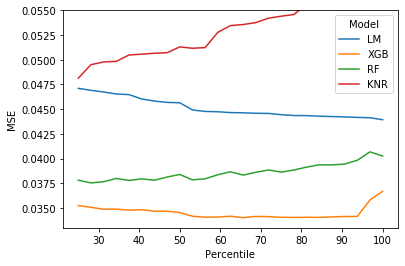

In [124]:
data = pd.melt(errors_p.astype(float), ['Percentile'])
data = data.rename(columns={"variable": "Model", "value": "MSE"})

sns.lineplot(data = data, x='Percentile',y='MSE',hue='Model')
plt.ylim([0.033,0.055])

## 4.2 Grid Search - Hyperparameter Tuning

The following code cells show how we used the 'GridSearchCV' function from Sklearn to get the best hyperparameters of our model. These cells do not reflect all hyperparameters tested, but rather function as an example of how we pin-pointed the best values. 

### 4.2.1 Grid Search - KNR

In [ ]:
knr = KNeighborsRegressor()

params = {'n_neighbors':[7,8,9,10,11,12,13]}

X_scaled = StandardScaler().fit_transform(X)

gs_cv = GridSearchCV(knr, params, verbose=3, n_jobs=-1, cv=KFold(n_splits=3), scoring = 'neg_mean_squared_error')
gs_cv.fit(X_scaled, y)
print("Best score:", -gs_cv.best_score_)
print("Best Hyperparameters: \n", gs_cv.best_estimator_)

### 4.2.2 Grid Search - Random Forest

In [ ]:
rf = RandomForestRegressor(random_state = 0,
                           n_jobs=-1)

params = {'max_features':['sqrt'],
          'min_samples_leaf':[2],
          'min_samples_split':[7,8],
          'max_depth': [45,40],
          'n_estimators': [250],
          'oob_score':['True']}

gs_cv = GridSearchCV(rf, params, verbose=3, n_jobs=-1, cv=KFold(n_splits=3), scoring = 'neg_mean_squared_error')
gs_cv.fit(X, y)
print("Best score:", -gs_cv.best_score_)
print("Best Hyperparameters: \n", gs_cv.best_estimator_)

### 4.2.3 Grid Search - XGBoost

In [ ]:
#Grid Search
GBoost = XGBRegressor()

params = {'min_child_weight':[1,1.1,],
          'gamma':[0,0.1],
          'colsample_bynode':[0.7],
          'colsample_bytree':[0.7],
          'colsample_bylevel':[0.8,0.9],
          'subsample':[1,0.9],
          'max_depth':[25],
          'n_estimators':[200],
          'learning_rate':[0.1],
          'max_features':['None']}

gs_cv = GridSearchCV(GBoost, params, verbose=3, n_jobs=-1, cv=KFold(n_splits=3), scoring='neg_mean_squared_error')
gs_cv.fit(X, y)
print("Best score:", -gs_cv.best_score_)
print("Best Hyperparameters: \n", gs_cv.best_estimator_)

## 4.3 Map Visualization

In order to run the following Cell block make sure to have folium version 7.0.0 installed.

In [ ]:
import folium
from folium.plugins import MarkerCluster, FloatImage
from folium import plugins, FeatureGroup, LayerControl, Map, Marker
from geopy.geocoders import Nominatim

gemeinden = df_train.groupby(['GDENAMK'])['rent_full','area'].mean().reset_index() 
gemeinden = pd.DataFrame(data=gemeinden)

gemeinden['rent_p_area'] = gemeinden['rent_full']/gemeinden['area'] # create average rent per square meter metric

# We rename these special characters as otherwise the mapping to the GEOJSON file doesn't work
gemeinden = gemeinden.replace({'GDENAMK': {'ä': 'ae', 'Ä': 'Ae', 'ü':'ue', 'Ü':'ue', 'ö':'oe', 'Ö':'Oe',
                                          'é':'e', 'è':'e', 'È':'E','É':'E','À':'A','à':'a','â':'a','Â':'A',
                                          ' (.+)':''}}, regex=True)


In [ ]:
Center = (46.979406005228284, 8.300191824322653) #define center of zurich

# file name - file is located in the working directory
gmde_geo = r'gemeinden4.geojson' # geojson file

# create a plain world map
gmde_map = folium.Map(location=Center, zoom_start=7.5, tiles='cartodbpositron',width=900,height=600, zoom_control=True)

# add tile layers to the map
tiles = ['cartodbpositron']
for tile in tiles:
    folium.TileLayer(tile).add_to(gmde_map)

# generate choropleth map 
folium.Choropleth(
    geo_data=gmde_geo,
    data=gemeinden,
    columns=['GDENAMK','rent_p_area'],
    key_on='feature.properties.gemeinde_NAME',
    fill_color='Reds', 
    fill_opacity=0.8,
    nan_fill_color="lightgray",
    nan_fill_opacity=0.5,
    line_opacity=0.1,
    legend_name='Average monthly rent per m^2',
    highlight = True,
    smooth_factor=0).add_to(gmde_map)


# create a layer control
folium.LayerControl().add_to(gmde_map)

# display map
gmde_map